<center>

# **22AIE401 - Reinforcement Learning**  
# **Lab 7**  

</center>

### Team Members:
- Guruprasath M R - AIE22015  
- Rudraksh Mohanty - AIE22046  
- Shree Prasad M - AIE22050  
- Tharun Kaarthik G K - AIE22062  

---

### Objective:
Smart Drone Navigation using Dyna-Q 
To implement and understand the Dyna-Q reinforcement learning algorithm in a partially known  environment, enabling a delivery drone to learn the optimal path to its target while avoiding obstacles. 


---

### Problem Statement:
A delivery drone operates in an 8×8 urban grid. Its goal is to deliver a package from the warehouse at (0,0) to a drop point at (7,7). However, certain grid cells represent buildings/obstacles, and movement into them incurs a penalty. The drone must learn to reach the target location in the shortest path with minimal penalty using the Dyna-Q algorithm. 
 


---

## Original Code

In [2]:
!sudo apt update
!sudo apt install ffmpeg


Hit:1 https://repo.anaconda.com/pkgs/misc/debrepo/conda stable InRelease
Hit:2 https://packages.microsoft.com/repos/microsoft-ubuntu-noble-prod noble InRelease
Hit:3 https://dl.yarnpkg.com/debian stable InRelease                           m
Hit:4 http://archive.ubuntu.com/ubuntu noble InRelease                         
Hit:5 http://archive.ubuntu.com/ubuntu noble-updates InRelease
Get:6 http://security.ubuntu.com/ubuntu noble-security InRelease [126 kB]
Hit:7 http://archive.ubuntu.com/ubuntu noble-backports InRelease
Fetched 126 kB in 3s (42.8 kB/s)  m                  
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
56 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:6.1.1-3ubuntu5).
0 upgraded, 0 newly installed, 0 to remove and 56 not upgraded.


✅ Drone navigation video saved as lab7_dyna_q_drone_navigation.mp4


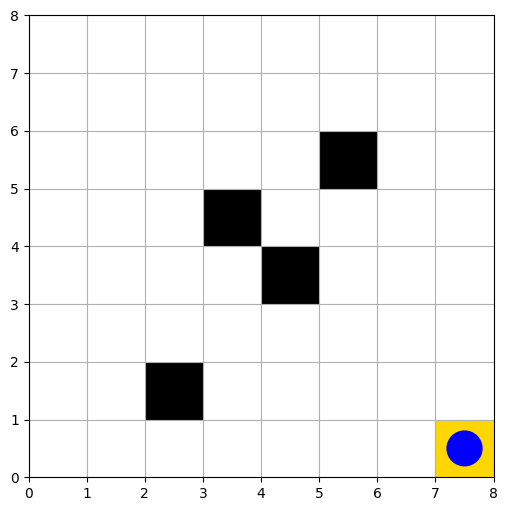

In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.patches as patches 
from matplotlib.animation import FuncAnimation, FFMpegWriter 
import random 
from collections import defaultdict 

# ---------------------- Environment Setup ---------------------- #
GRID_SIZE = 8
ACTIONS = ['U', 'D', 'L', 'R'] 
ACTION_MAP = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)} 
GOAL = (7, 7) 
OBSTACLES = {(3, 3), (4, 4), (2, 5), (6, 2)} 
REWARD_GOAL = 100
REWARD_STEP = -1
REWARD_OBSTACLE = -10
EPISODES = 300
MAX_STEPS = 50
EPSILON = 0.1
ALPHA = 0.1
GAMMA = 0.95
PLANNING_STEPS = 10
Q = defaultdict(lambda: {a: 0 for a in ACTIONS}) 
model = {} 

def is_valid(pos): 
    return 0 <= pos[0] < GRID_SIZE and 0 <= pos[1] < GRID_SIZE and pos not in OBSTACLES 

def step(state, action): 
    dx, dy = ACTION_MAP[action] 
    next_state = (state[0] + dx, state[1] + dy) 
    if not is_valid(next_state): 
        return state, REWARD_OBSTACLE 
    if next_state == GOAL: 
        return next_state, REWARD_GOAL 
    return next_state, REWARD_STEP 

def select_action(state): 
    if np.random.rand() < EPSILON: 
        return random.choice(ACTIONS) 
    return max(Q[state], key=Q[state].get) 

# ---------------------- Dyna-Q Training ---------------------- #
for ep in range(EPISODES): 
    state = (0, 0) 
    for _ in range(MAX_STEPS): 
        action = select_action(state) 
        next_state, reward = step(state, action) 
        # Q-learning update
        best_next = max(Q[next_state], key=Q[next_state].get) 
        Q[state][action] += ALPHA * (reward + GAMMA * Q[next_state][best_next] - Q[state][action]) 
        # Model learning
        model[(state, action)] = (next_state, reward) 
        # Planning updates
        for _ in range(PLANNING_STEPS): 
            s, a = random.choice(list(model.keys())) 
            s_, r = model[(s, a)] 
            best_s_ = max(Q[s_], key=Q[s_].get) 
            Q[s][a] += ALPHA * (r + GAMMA * Q[s_][best_s_] - Q[s][a]) 
        if next_state == GOAL: 
            break
        state = next_state 

# ---------------------- Extract Path ---------------------- #
path = [(0, 0)] 
state = (0, 0) 
for _ in range(30): 
    action = select_action(state) 
    state, _ = step(state, action) 
    path.append(state) 
    if state == GOAL: 
        break

# ---------------------- Visualization Setup ---------------------- #
fig, ax = plt.subplots(figsize=(6, 6)) 
drone_patch = patches.Circle((0.5, 0.5), 0.3, color='blue') 

def init(): 
    ax.clear() 
    ax.set_xlim(0, GRID_SIZE) 
    ax.set_ylim(0, GRID_SIZE) 
    ax.set_xticks(np.arange(GRID_SIZE + 1)) 
    ax.set_yticks(np.arange(GRID_SIZE + 1)) 
    ax.grid(True) 
    for i in range(GRID_SIZE): 
        for j in range(GRID_SIZE): 
            cell = (i, j) 
            color = 'white'
            if cell in OBSTACLES: 
                color = 'black'
            elif cell == GOAL: 
                color = 'gold'
            rect = patches.Rectangle((j, GRID_SIZE - i - 1), 1, 1, facecolor=color) 
            ax.add_patch(rect) 
    return [] 

def update(frame): 
    init() 
    rx, ry = path[frame] 
    drone_patch.center = (ry + 0.5, GRID_SIZE - rx - 0.5) 
    ax.add_patch(drone_patch) 
    return [drone_patch] 

anim = FuncAnimation(fig, update, frames=len(path), init_func=init, blit=True) 

# ---------------------- Save to Video ---------------------- #
save_path = "lab7_dyna_q_drone_navigation.mp4"
writer = FFMpegWriter(fps=2, metadata=dict(artist='RL Lab 7'), bitrate=1800) 
anim.save(save_path, writer=writer) 
print(f"✅ Drone navigation video saved as {save_path}")